In [83]:
%load_ext autoreload
%autoreload 2
from oogeso import multicarrier
from oogeso import plots
import matplotlib.pyplot as plt
import IPython
import pyomo.environ as pyo
import logging
plots.plotter='plotly'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [91]:
datafile = "data_test2.xlsx"
data,profiles = multicarrier.read_data_from_xlsx(datafile)

for dev in ['GT1','GT2']:
    data['paramDeviceOnTimestepsInitially'][dev] = 10
    data['paramDeviceIsOnInitially'][dev] = 1

#plots.plotProfiles(profiles)

In [92]:
mc = multicarrier.Multicarrier(loglevel="INFO")
mc.createModelInstance(data,profiles)

2020-11-03 12:44:29 INFO: TODO: objective function definition
2020-11-03 12:44:29 INFO: TODO: separator power (eta) and heat (eta2) demand
2020-11-03 12:44:29 INFO: TODO: gas turbine power vs heat output
2020-11-03 12:44:29 INFO: TODO: startup cost
2020-11-03 12:44:30 INFO: TODO: el source: dieselgen, fuel, on-off variables
2020-11-03 12:44:30 INFO: TODO: liquid pump approximation ok?
2020-11-03 12:44:30 INFO: TODO: startup delay does not work with Pmin>0
2020-11-03 12:44:30 INFO:       -use of prevHasBeenOn does not work as intended
2020-11-03 12:44:30 INFO: TODO: flow vs pressure equations for liquid flows
2020-11-03 12:44:30 INFO: TODO: pressure deviation limits per node
2020-11-03 12:44:30 INFO: TODO: Update Pmin constraint to allow GT startup delay
2020-11-03 12:44:30 INFO: Valid elReserveMargin not defined -> no constraint


In [93]:
status = mc.solveMany(solver="cbc",timerange=[0,1],write_yaml=False)

2020-11-03 12:44:30 INFO: Solving timestep=0


In [94]:
mc.instance.constrDevice_startup_delay.pprint()

constrDevice_startup_delay : Size=270, Index=constrDevice_startup_delay_index, Active=True
    Key            : Lower : Body                                                    : Upper : Active
     ('GT1', 0, 0) :  -Inf :   varDeviceFlow[GT1,el,out,0] - 20*varDeviceIsOn[GT1,0] :   0.0 :   True
     ('GT1', 1, 0) :  -Inf :   varDeviceFlow[GT1,el,out,1] - 20*varDeviceIsOn[GT1,1] :   0.0 :   True
     ('GT1', 1, 1) :  -Inf :   varDeviceFlow[GT1,el,out,1] - 20*varDeviceIsOn[GT1,0] :   0.0 :   True
     ('GT1', 2, 0) :  -Inf :   varDeviceFlow[GT1,el,out,2] - 20*varDeviceIsOn[GT1,2] :   0.0 :   True
     ('GT1', 2, 1) :  -Inf :   varDeviceFlow[GT1,el,out,2] - 20*varDeviceIsOn[GT1,1] :   0.0 :   True
     ('GT1', 2, 2) :  -Inf :   varDeviceFlow[GT1,el,out,2] - 20*varDeviceIsOn[GT1,0] :   0.0 :   True
     ('GT1', 3, 0) :  -Inf :   varDeviceFlow[GT1,el,out,3] - 20*varDeviceIsOn[GT1,3] :   0.0 :   True
     ('GT1', 3, 1) :  -Inf :   varDeviceFlow[GT1,el,out,3] - 20*varDeviceIsOn[GT1,2] :   0.0 

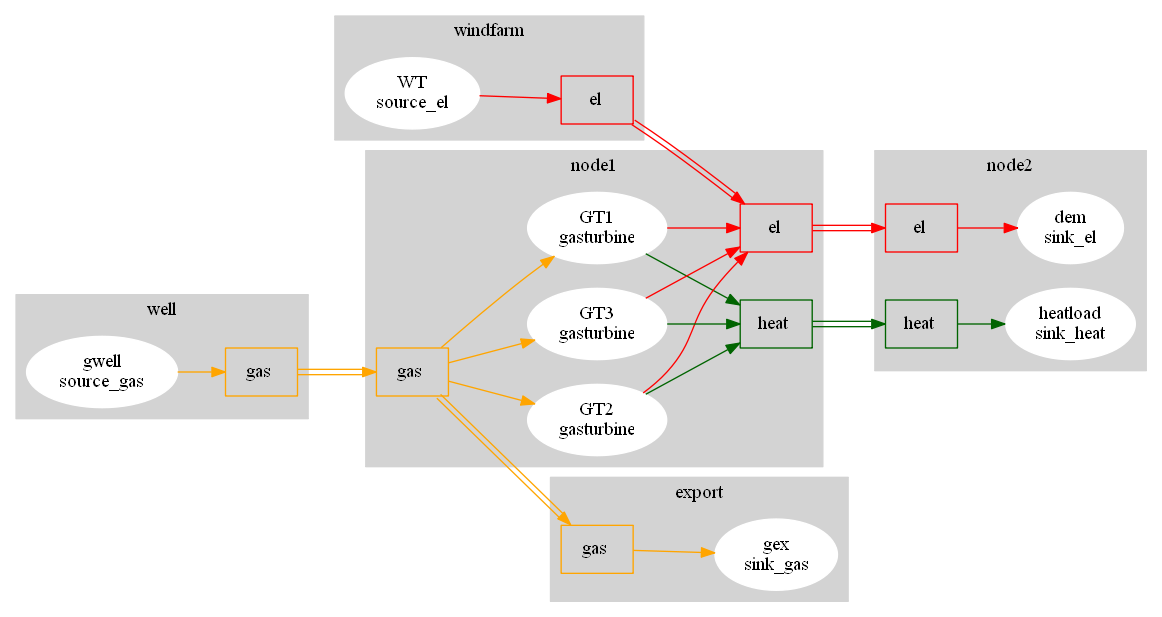

In [42]:
dotG=plots.plotNetwork(mc,timestep=None,filename=None)
#IPython.display.SVG(dotG.create_svg()) #original size, vector graphics
IPython.display.Image(dotG.create_png()) #scales automatically to page width

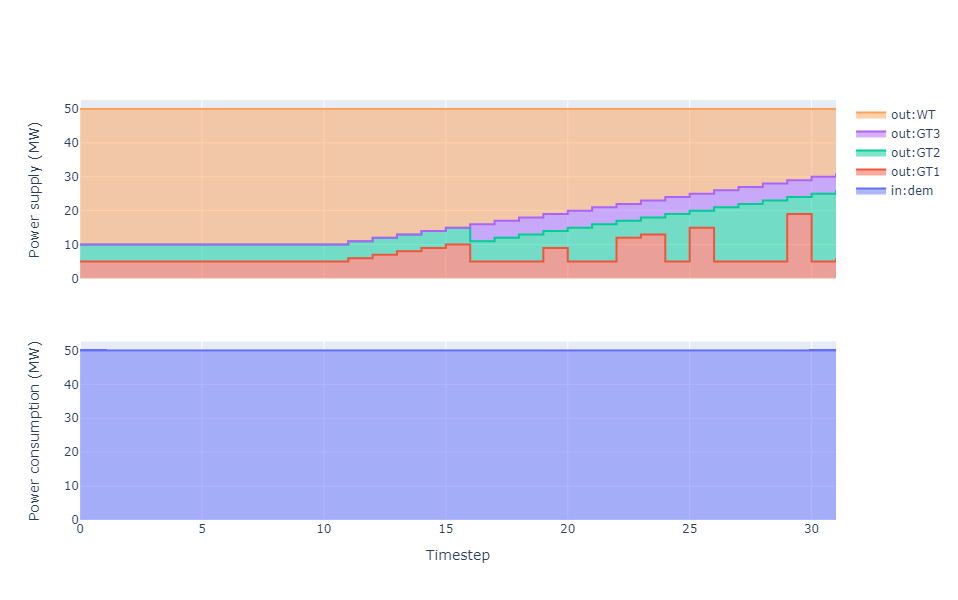

In [37]:
fig=plots.plot_SumPowerMix(mc,carrier="el")

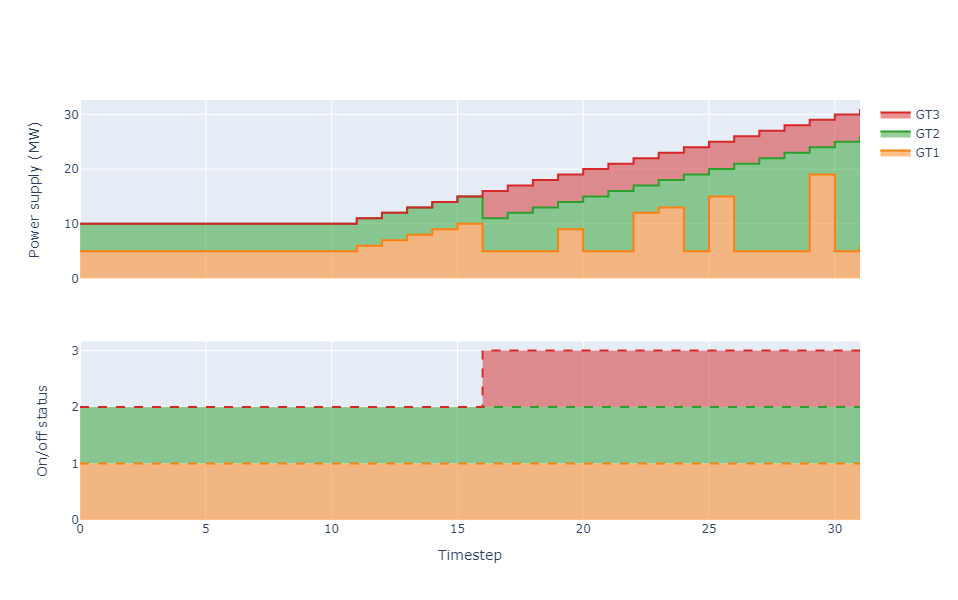

In [19]:
plots.plot_deviceprofile(mc,devs=['GT1','GT2','GT3'],includeOnOff=True)

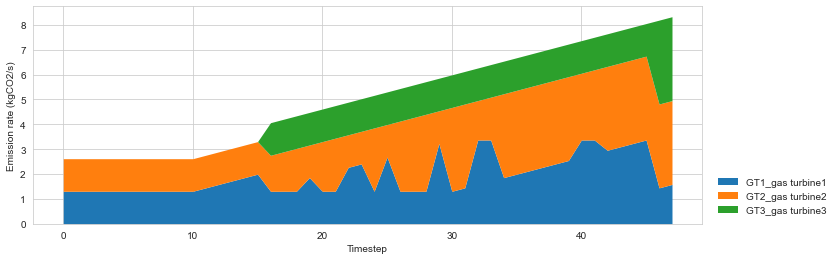

In [165]:
#plots.plot_CO2rate(mc)
plots.plot_CO2rate_per_dev(mc)

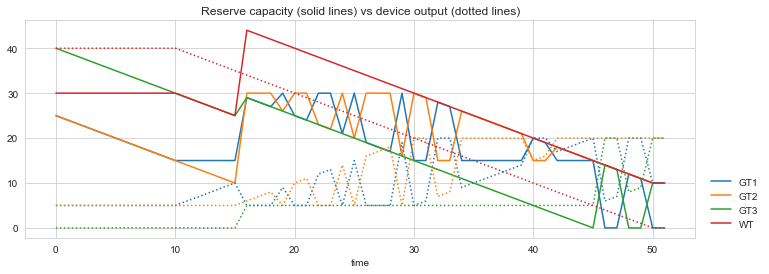

In [13]:
plots.plotElReserve(mc)